In [2]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from graphviz import Digraph

# The Common Cause

There are three major types of causal networks that we have to be careful around; mediators, common causes, and colliders. In each case, there is a question about which variables to include in our causal model and when to include them. Graph theory gives some answers. Today we'll explore the common cause. Next class we'll explore the collider.

Here's the motiviating story. You might be interested to know whether spending more time in higher education will increase your lifetime income. It seems intuitive that there would be some positive causal effect of education on income. But there is also a tradeoff - the more time you spend in school, the less time you spend in the workforce actually making the money. So getting some kind of precise estimate of the causal effect might be important. Data on the relationship wouldn't be terribly hard to find. You could, for example, look at Linkedin profiles and collect records on people's education level and their current job. You could match the job title up with aggregated average salary estimates to get a ballpark figure.

Here's the problem - whatever inference you draw is likely confounded by an unmeasured third variable: intelligence. Intelligence causes people to go to school for longer. Those folks like school and tend to be good at it. Good grades make it easier to get scholarship and get admitted to even more higher education. Intelligence also causes higher incomes. You perform better at work, you get promoted faster, you interview well, etc. So a causal graph of our system might look this:

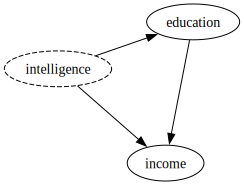

In [3]:
G = Digraph()
G.graph_attr['layout'] = 'neato'

G.node("a",'education',pos="200,400")
G.node("b",'intelligence',pos="0,200",style="dashed")
G.node("c","income",pos="100,0")

G.edge("a",'c',len='2.0')
G.edge("b",'a',len='2.0')
G.edge("b",'c',len='2.0')

G

If this is the correct causal system, then spending more time in school might not help your income much. If intelligence is the primary driver, you might as well leave school early.

The idea of confounding due to a third variable is probably familiar to many of you. What will be new is the way we can fit this concept into a full "graph -> simulate -> bayesian inference" framework. So let's start programming a simulation that obeys this causal structure. Here's a first pass. 

In [36]:
intelligence = np.random.choice([0,1,2,3],size=50)

# years of education, rounded to year

education = intelligence + 6
education = np.round(education,0)

# every year adds 100 dollars to weekly income. Every intelligence rank adds 200

income = 300 + 100 * education + 200 * intelligence
income


array([1500,  900,  900,  900, 2100, 2100,  900, 1200,  900, 1200, 1200,
       1500, 1200, 1200, 2100, 1500,  900, 2100,  900, 1500, 2100,  900,
       2100,  900,  900, 1500, 2100, 1500, 2100, 1200, 2100, 1200, 1500,
       1500,  900,  900, 2100, 1500, 1500, 1200, 1200, 1200, 1200, 1500,
       1500, 2100, 2100,  900, 1500, 1200])

The important thing is just capturing the right causal relationships. The specific parameters, like setting the education effect to $100 dollars, are arbitrary. Similarly, using discrete levels for intelligence is also arbitrary. We could also use a continuous scale like IQ. My advise is to program the simulation in whatever way feels intuitive. Sometimes you want to pick realistic numbers to help you reason. Other times you can just people easy numbers to add and multiply like `1-5` if that feels easier.

## Adding noise

Our simulation is missing noise terms. Other things contribute to your education other than your intelligence - where you live, how much money your parents make, whether your teachers are kind to you or not, whether you make close friends in school. Similarly, other things contribute to income other than education.

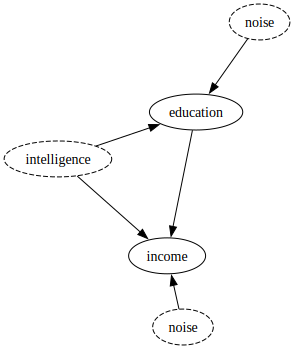

In [64]:
G = Digraph()
G.graph_attr['layout'] = 'neato'

G.node("a",'education',pos="200,400")
G.node("b",'intelligence',pos="0,200",style="dashed")
G.node("c","income",pos="100,0")
G.node('d','noise',style="dashed")
G.node('e','noise',style="dashed")

G.edge("a",'c',len='2.0')
G.edge("b",'a',len='2.0')
G.edge("b",'c',len='2.0')
G.edge('d','c')
G.edge('e','a',len='1.5')

G

You might be surprised that I omit noise on intelligence. As usual, whenever you feel something is weird in the simulation, you can play around with. Try adding noise onto the graph and then the simulation and see what happens. 

I will spoil the results of your experiment a little bit: nothing. intelligence might be a product of some complicated causal process that is invisible on this graph. But that doesn't matter to the question of the effect of intelligence on income. It doesn't matter where intelligence comes from, it just matter what it does. We sorta implicitly had a noise term in our simulation: when we randomly generate the values for intelligence, that's like saying they are a product of some noise process. Adding noise onto intelligence is just adding noise onto noise.

There is a nice lesson here: rarely in life or science will we know the "full" causal structure. We usually only need to represent a slice of the world to get effective inferences. It's delicate around the edges, omitting mediators, colliders, or common causes, that are important can bias our estimates. But loads of causes can safely be left out without causing any trouble. Even if mediators, colliders, and common causes, they might have only a very small effect size. In those causes, sure our inference will be biased but not by much.

Anyway, here's the simulation with noise.

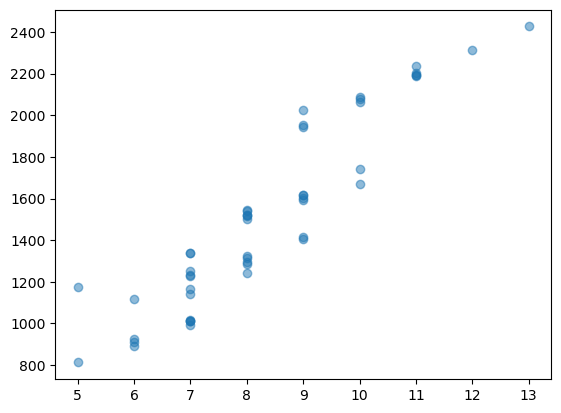

In [4]:
intelligence = np.random.choice([0,1,2,4],size=50)

# years of education, rounded to year

education = intelligence + 6 + np.random.normal(0,1,size=50)
education = np.round(education,0)

# every year adds 100 dollars to weekly income. Every IQ point adds 2 dollars.

income = 300 + 100 * education + 200 * intelligence + np.random.normal(0,30,size=50)

plt.plot(education,income,'o',alpha=0.5)

## Overestimating the causal effect of education

Now the question is, if I want to know the effect of education on income, which variables should I include? We know from our simulation that the education effect is +100. We can either include education + intelligence or just education. Let's try it both ways and see what happens.

In [40]:
with pm.Model() as overestimate:

    a = pm.Normal('base income',1000,500) 
    b = pm.Normal('education effect',0,200)
    s = pm.Exponential('noise',scale=50)
    
    mean = a + b*education
    
    y = pm.Normal('income',mean,s,observed=income)

It will also be nice to see another example of prior predictive simulation. When we want to know the range of plausible relationship between `x` and `y`, we can graph it like this:

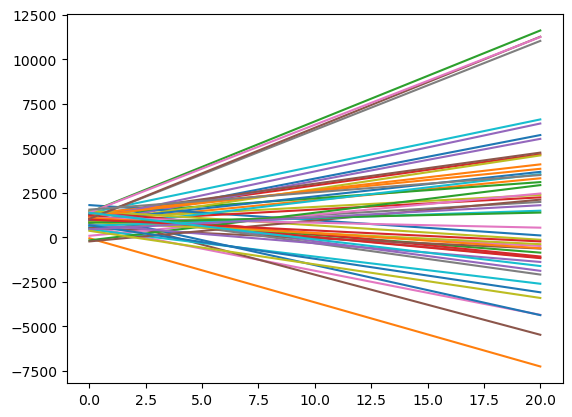

In [41]:
a_samples,b_samples = pm.draw([a,b],draws=50)

x_grid = np.linspace(0,20)

for i in range(50):
    y = a_samples[i] + b_samples[i]*x_grid
    plt.plot(x_grid,y)
    

Our prior simulation, in this context, isn't super important. We don't have any real world context to incorporate into our model. We also already know the correct parameter values so putting priors out there is a bit of a farce. However, if our prior simulation show that we didn't permit enough possible relationships, we could artificially bias our model by discounting the true answer. So building some simple priors which have wide uncertainty over them will be helpful in making this hypothetical example more compelling.

In [42]:
with overestimate:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [base income, education effect, noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


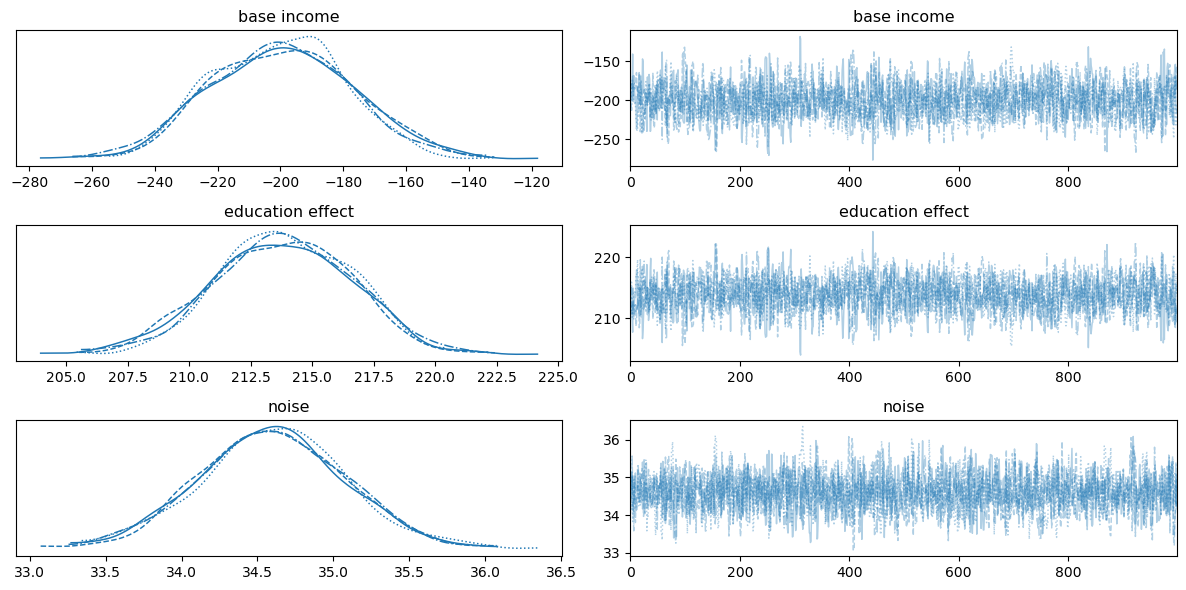

In [43]:
az.plot_trace(trace)
plt.tight_layout();

Our resulting estimate is 200, which is 2 times larger than it's supposed to be. If we want to know the effectiveness of education, this statistical model overestimates their effectiveness by a large amount. Why? Well it's tracking correlations that are not causal correlations. There is a strong correlation between education and income. Part of that is directly causal. But a large part of that is a correlation induced by their common cause in optimism.

## Correctly estimating the effect

By contrast, putting both varibles into the model gives us great results: it learns the causal effect of intelligence and education correctly.

In [47]:
with pm.Model() as deconfounding:

    a = pm.Normal('base income',1000,500) 
    b1 = pm.Normal('education effect',0,200)
    b2 = pm.Normal('intelligence effect',0,200)
    s = pm.Exponential('noise',50)
    
    mean = a + b1*education + b2*intelligence
    
    y = pm.Normal('headache',mean,s,observed=income)

In [48]:
with deconfounding:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [base income, education effect, intelligence effect, noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


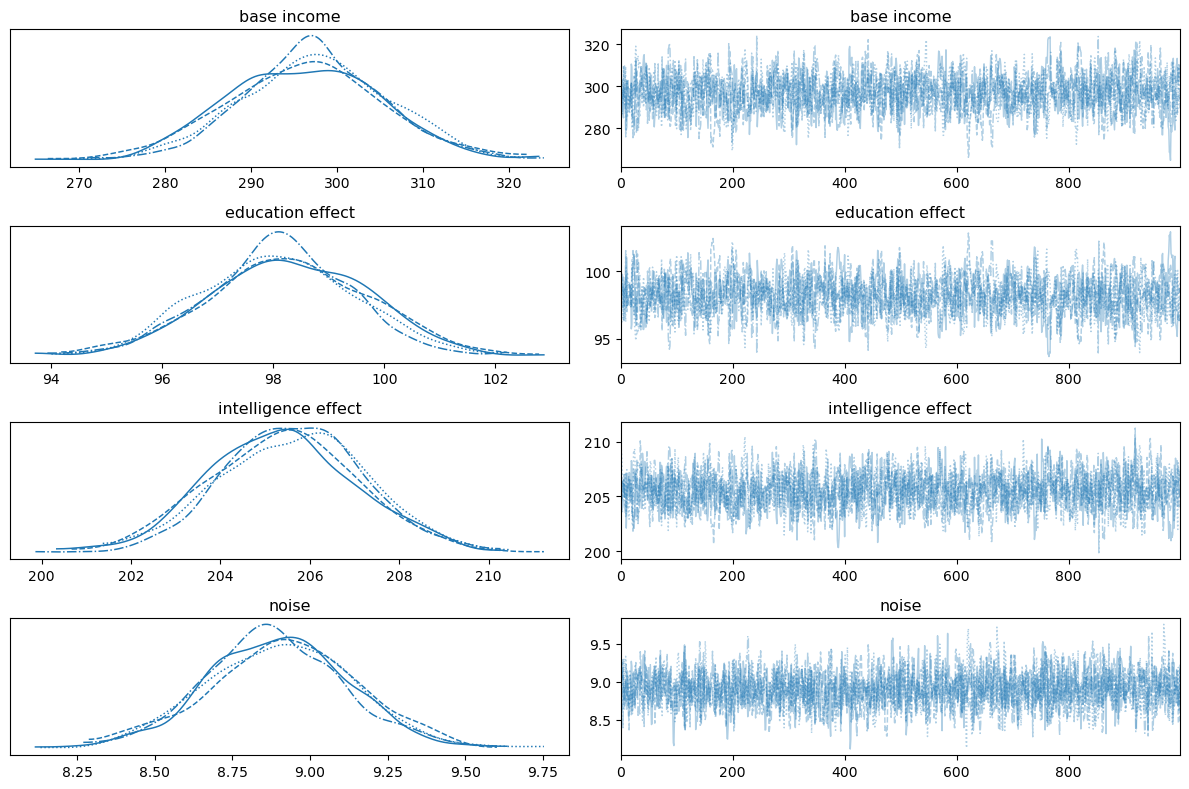

In [49]:
az.plot_trace(trace)
plt.tight_layout();

## Why do we love randomized controlled experiments?

There is also a bigger lesson here about why we conduct randomized controlled experiments. When we randomly assign participants to conditions, can (usually) prevent this sort of confounding. The experimenter decides who is in what group, not any other variable. It's a bit hard to imagine in this context but, in principle, we could randomizely assignment people to take different educational pathways. In that case, intelligence levels would be, on average, equal in all conditions. We get a similar mix of intelligences in the high school-only, undergrad-only, masters, and phd groups. If we could pull that off, then we could successfully estimate the causal effect of education without measuring intelligence.

So randomization is like erasing a causal arrow that flows into the treatment you are studying.

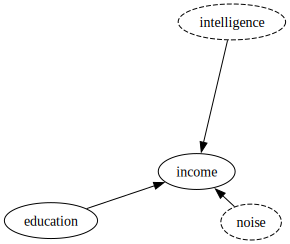

In [65]:
G = Digraph()
G.graph_attr['layout'] = 'neato'

G.node("a",'education')
G.node("b",'intelligence',style="dashed")
G.node("c","income",pos="100,0")
G.node('d','noise',style="dashed")

G.edge("a",'c',len='2.0')
# G.edge("b",'a',len='2.0') we erase this connection when we control education
G.edge("b",'c',len='2.0')
G.edge('d','c')

G

But we learned that this causal graph can really just be simplified into:

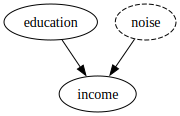

In [57]:
G = Digraph()

G.node("a",'education')
G.node("c","income")
G.node('e','noise',style="dashed")

G.edge("a",'c')
G.edge('e','c')

G

We often cannot directly measure all the variables we might care about. There is a fairly good public paper trail that documents people's jobs and education levels. There isn't a similarly good paper trail for intelligence - not everyone takes an IQ test, those scores aren't typically public. So if we did have data on intelligence, we could deconfound by including that data in a statistical model. If we don't have data but have the power to perform a randomized controlled trial, we could also deconfound the relationship. Two equally good strategies for the same goal.

Randomized controlled trials are not bullet-proof, however, we'll see an example in a moment that suggests common cause-based confounding can happen there too. It's just that our story has to get more complicated. Before we explore that, however, we need to expand our modeling toolkit one more time.

# Linear functions for count data

We learned in last lecture that we can often rewrite our models as linear functions. The linear function approach has a lot of benefits:

- It makes models more compact - fewer lines of code means fewer mistakes. 
- It makes it a bit easier to set priors, sometimes, we just have to think about how big of effect could we plausibly have and then set a $\text{Normal}(0,s)$ where s is somewhere near our ceiling on big effects. 
- It allows us to treat causes as additive components. That's especially useful for causal graph models where we need multiple arrows flowing into a node.

The linear function approach works great for continuous outcome data - walking speeds and the like. But it might give us some trouble with discrete count data. Let's imagine I'm trying to model the propensity to conform as a function of agreeableness. Agreeableness is one of the so-called "Big Five" personality traits. Imagine people come in 5 levels of agreeableness and we've collected personality data on our participants before sending them into the Asch experiment. 

If propensity to conform is caused by agreeableness, we might have simulation like this:

In [5]:
agreeableness = np.random.choice([0,1,2,3,4,5],size=50)

p = 0.1 + 0.1*agreeableness

y = np.random.binomial(p=p,n=12)
y

array([ 4,  1,  4,  8,  2,  0,  1,  1,  1,  8,  2,  6,  4,  3,  8,  8,  7,
        9,  1,  7,  3, 11,  3,  4,  3,  0,  5,  4,  3,  3,  5,  4,  5,  0,
        1,  3,  5,  8,  1,  5,  1,  4,  6,  2,  5,  8,  3,  5,  0,  4])

That code runs just fine. This code, however, doesn't.

In [5]:
agreeableness = np.random.choice([0,1,2,3,4,5],size=50)

p = 0.1 + 0.2*agreeableness

y = np.random.binomial(p=p,n=12)
y

ValueError: p < 0, p > 1 or p contains NaNs

When `agreeableness = 5`, we get `p = 0.1 + 0.2*5` or `p=1.1`. But `p` must be between 0 and 1. It's a probability of success or failure. There a bunch of ways we could modify our example to put the domain constraint. In unit 1, we just wrote `if` statements to check if we've violated a boundary. Those are fine as a quick and dirty approach. But they have some awkward features. Once you are over the ceiling, it doesn't matter how much over the ceiling you are. That will lead to a host of problems with our Markov Chain algorithm.

Instead, an elegant solution is to transform our linear function with something know as the invlogit transform. The math looks funny. The priors will be a little odd. But the key thing to remember is - *invlogit takes a linear function and compresses it to fit between 0 and 1.*

In symbols it looks like this:

$$y = \frac{e^{a + b*x}}{1 + e^{a + b*x}}$$

You'll notice that the $a + b*x$ bit is the same linear function we used in the last lecture. The rest is just the compression machinery. In python, the transform function is:

In [7]:
def invlogit(linear_func):
    return np.exp(linear_func) / (1 + np.exp(linear_func))

Looking at graphs is much easier than staring at symbols. On the left we have an normal linear function. On the right we have same linear function but compressed by this transformation. Notice, first, the y-axis on the right graph - it's contained between `[0, 1]`. Notice, also, the x-axis on the right graph. When the value of the linear function goes to -4 or 4, then the invlogit function nearly hits the ceiling or floor. The function never actually hits the 0 or 1. As you increase the linear function, the value of the invlogit function gets closer and closer. But for most purposes, 4/-4 is essentially the ceiling or floor.

Text(0.5, 1.0, 'Logistic function')

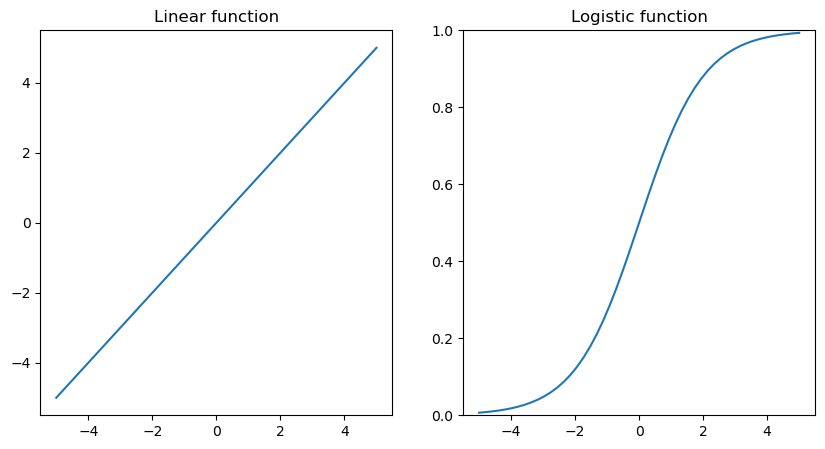

In [8]:
f, ax = plt.subplots(ncols=2,figsize=(10,5))

x = np.linspace(-5,5)

a = 0
b = 1

y = a + b*x
p = invlogit(a + b*x)

ax[0].plot(x,y)
ax[1].plot(x,p)
ax[1].set_ylim([0,1])
ax[0].set_title('Linear function')
ax[1].set_title("Logistic function")

We can check this trick works by dropping it into our old problem. The graph shows the intuitive behaviour - as you get more agreeable, you also conform more often. At each point, dots spread out around some central value, just like they do with a binomial distribution. So we can think of this as similar to the Normal regressions we saw last time.

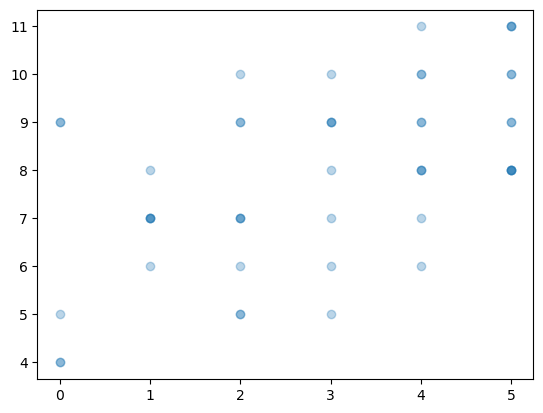

In [20]:
agreeableness = np.random.choice([0,1,2,3,4,5],size=50)

p = invlogit(0.1 + 0.2*agreeableness)

y = np.random.binomial(p=p,n=12)
plt.plot(agreeableness,y,'o',alpha=0.3)

Setting priors in the context of the inverse logit is a bit more challenging. Normally, if we want to express uncertainty on where our parameters are, we set wide standard deviations on the priors. Here my priors say "my best guess for `a,b` is 0, but I'm really not sure. They reasonably could be as high as 30 and as low as -30."

In [10]:
with pm.Model() as bad_logistic_priors:
    a = pm.Normal('a',0,10)
    b = pm.Normal('b',0,10)

    p = pm.math.invlogit(a + b*x)

It turns out that, when you transform this function, it doesn't really express uncertainty anymore. The values of `p` are clumped up near 1 and down near 0, with very few in-between. That's weird though. We tried to express uncertainty and ended up saying, more or less, "I know `p` is either 0 or 1". It's a familiar lesson. In many contexts, trying to make your priors as flat as possible isn't possible or advisable. 

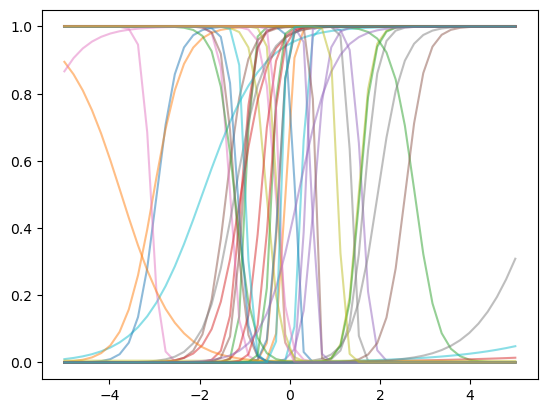

In [11]:
samples = pm.draw(p,draws=50)

for i in samples:
    plt.plot(x,i,alpha=0.5)

The problem arises because most of the values we could pull out of the prior distribution are fairly large, like 5, 10, 15. We learned earlier that when the linear function is bigger than 4, the invlogit function is nearly 1. So a lot of these prior parameter values push our function into the same conclusion.

Instead, we can set tighter priors on the natural scale in order better represent uncertainty on the invlogit scale.

In [12]:
with pm.Model() as good_logistic_priors:
    a = pm.Normal('a',0,3)
    b = pm.Normal('b',0,1.5)

    p = pm.math.invlogit(a + b*x)

These priors produce a predictive plot that is well-mixed and better matches our state of knowledge. You can use these priors as good baseline and adjust them as needed for new contexts with different levels of background knowledge.

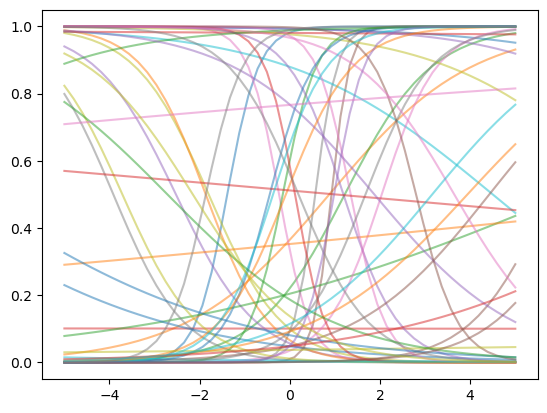

In [13]:
samples = pm.draw(p,draws=50)

for i in samples:
    plt.plot(x,i,alpha=0.5)

At this point in the course, I hope you'll be convinced. Interpreting priors is hard work. Make it easy on yourself by plotting them, especially whenever designing a new kind of model.

Expanding the linear function framework to handle count data will allow us build some more interesting causal graphs, a topic we turn back to now.

# Mediators and common causes, at the same time

Earlier, I noted that experiments are not a bullet-proof technique for causal inference. Once we start to consider more complex causal graphs, we can generate really interesting scenarios that bias experiments too. One general problem in experimental design is that not all the participants do what you tell them to do. For example, what if some participants didn't finish the priming task? They unscrambled a few words, quit, turned in their sheet of paper and left. This scenario is made up but it can illustrate a general problem. We might draw a causal graph like this:

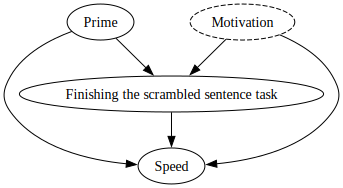

In [21]:
G = Digraph()

G.node("a",'Prime')
G.node("b","Finishing the scrambled sentence task")
G.node('c','Motivation',style="dashed")
G.node("d","Speed")

G.edge("a",'b')
G.edge('c','b')
G.edge('b','d')
G.edge("a","d")
G.edge('c','d')
G

This graph needs some justification. First, priming might cause systematic differences in who finishs the sentence task. Those in the elderly-primed group might get so so sleepy that they give up early. Those in the control group might be unbothered and finish it consistently.

Second, both priming and finishing the task might cause differences in speed. Maybe priming has a dose-response relationship. The more scrambled sentences you finish, the more primed you are. So starting the task causes a little bit but finishing causes an extra dose.

Third, there might be an unmeasured common cause of finishing the task and speed. We'll call it motivation. Motivated people like to get where they are going. They also like following directions.

If we were faced with a scenario like this, what kind of statistical model should we build? What variables do we have to include to get the correct estimate? The answer is not at all obvious so we'll work through the puzzle systematically. Let's code up a simulation.

In [71]:
invlogit(0.5)

0.6224593312018546

In [94]:
n = 1000
primed = np.random.choice([0,1],size=n)
motivation = np.random.choice([0,1],size=n)

# whether you finish the task is binary (0-1). 
# So we'll need to use our brand new invlogit 
# trick.

p = invlogit(1.5 + -2.5*primed + 2*motivation)
finished = np.random.binomial(n=1,p=p)

speed = 9 + 1 * finished - 1 * motivation + 0.5 * primed + np.random.normal(0,0.5,size=n)

We are going to try three statistical models and see which one does a good job. In this case, we are looking for either a direct effect (0.5 for priming) or perhaps a total effect (1.5 if you add finished and priming effect sizes). The first model will just include priming. The second will include priming and whether they finished the task or not. The final one will include all three variables. Along the way, we'll try to reason through why some models fail and others succeed.

In [98]:
with pm.Model() as total_effect:
    a = pm.Normal('a',10,5)
    b1 = pm.Normal('b1',0,5)
    s = pm.Exponential('s',1)

    m = a + b1*primed

    y = pm.Normal('y',m,s,observed=speed)

    trace_total_effect = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [99]:
az.summary(trace_total_effect)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,9.433,0.033,9.374,9.498,0.001,0.001,2020.0,2751.0,1.0
b1,0.041,0.047,-0.049,0.128,0.001,0.001,2032.0,2599.0,1.0
s,0.729,0.016,0.699,0.760,0.000,0.000,2786.0,2744.0,1.0


Our estimate is pretty firmly wrong. The correct value is 0.5 for the direct effect. This is unsurprising though, we've neglected a mediator.

More strangely though, we also don't get the total effect. In the last lecture, if we ignored a mediator, we just recovered the total effect. In this context, I would be pretty happy with a total effect, as it would give us something like an average over those who finish and those who don't. Let's try fixing the problem by including the meditator.

In [97]:
with pm.Model() as mediator_only:
    a = pm.Normal('a',10,5)
    b1 = pm.Normal('b1',0,5)
    b2 = pm.Normal('b2',0,5)
    s = pm.Exponential('s',1)

    m = a + b1*primed + b2*finished

    y = pm.Normal('y',m,s,observed=speed)

    trace_mediator_only = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, b2, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [81]:
az.summary(trace_mediator_only)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,8.714,0.060,8.601,8.824,0.002,0.001,1371.0,2023.0,1.0
b1,0.680,0.049,0.584,0.766,0.001,0.001,1615.0,2103.0,1.0
b2,0.778,0.055,0.672,0.881,0.001,0.001,1592.0,2333.0,1.0
s,0.677,0.015,0.649,0.705,0.000,0.000,3283.0,2780.0,1.0


Including the mediator in the causal doesn't quite work. Our estimate are still biased. This isn't a problem with noise or sample size. We can turned down the noise or turn up the sample size all we like (I'm using 1000 samples in this problem!) and we won't find our answers.

The mediator, finishing, is biased by a common cause. So it's obvious that we won't identify the effect of finishing on speed. What is more surprising, however, is that the common cause also indirectly biases our estimate of the direct effect of priming on speed. Let's see how a model that includes motivation does.

In [95]:
with pm.Model() as all_causes:
    a = pm.Normal('a',10,5)
    b1 = pm.Normal('b1',0,5)
    b2 = pm.Normal('b2',0,5)
    b3 = pm.Normal('b3',0,5)
    s = pm.Exponential('s',1)

    m = a + b1*primed + b2*finished + b3*motivation

    y = pm.Normal('y',m,s,observed=speed)

    trace_all_causes = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, b2, b3, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [96]:
az.summary(trace_all_causes)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,9.060,0.041,8.983,9.136,0.001,0.001,1332.0,2348.0,1.0
b1,0.447,0.035,0.377,0.510,0.001,0.001,1955.0,2421.0,1.0
b2,0.969,0.041,0.895,1.044,0.001,0.001,1698.0,2283.0,1.0
b3,-0.989,0.034,-1.052,-0.927,0.001,0.000,3360.0,2715.0,1.0
s,0.507,0.012,0.485,0.528,0.000,0.000,3668.0,2599.0,1.0


Very well! All these are quite close to the true values. If we could somehow measure people's motivation, then we'd be safe to advocate a causal conclusion to our study. If we can't, we should hold back.

This example illustrates that reasoning about complicated causal systems can be challenging. You can deconfound one variable only to be reconfounded by another. Next class we'll learn some rules for reasoning through arbitrarily complex causal graphs systems.

The other upshot of this section is an, in principle, proof that randomized controlled experiments do not alway ensure causal inference. If there is a mediator, that mediator is not itself randomized or controlled. So the mediator is potentially vulnerable to confounding by a common cause. If we could somehow randomly assign people to four experimental conditions:

- primed, finished
- primed, didn't finish
- unprimed, finish
- unprimed, didn't finish

then we'd break the association between motivation and finishing the task and it would be more like the first example. But that can be challenging. You can only control humans so much. At some point, they have agency in the experimental process and the agency is the source of confounding.

Of course, whether your typical experiment with some incompletion will depend on whether you think this sort of causal graph is plausible. I had to make the somewhat silly assumption that priming causes systematic differences in whether you finish unscrambling the sentences. If that's not true, then we just have some random noise processes that cause people to finish or not finish. Our graph looks like this.

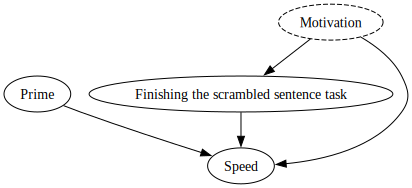

In [101]:
G = Digraph()

G.node("a",'Prime')
G.node("b","Finishing the scrambled sentence task")
G.node('c','Motivation',style="dashed")
G.node("d","Speed")

G.edge('c','b')
G.edge('b','d')
G.edge("a","d")
G.edge('c','d')
G

In this case, we can cleanly estimate the effect of priming on speed without bothering with motivation, or, even whether they finished or not.

# How to use causal graphs as a critical tool

The final section of this lecture will give you some practical guidance for approaching the final project. It's one thing to have a inventory of logical tools. It's another to know how to write about them effectively. So I thought I would walk through a general style of argument and describe how I would package it.

Causal confounding can be a hard topic to write about because it often involves speculating about data which you did not collect. We have to speculate about what unmeasured variables might be out there. Or, what kind of causal relationships do they have? It's awkward to write about data which doesn't exist. But it could still be quite relevant to the logical coherence of the original experiment.

To deploy an effective argument based on unmeasured confounding, we need to show that the original model *could* have given biased results under certain assumptions. So a nice process do that works like this:

1. build statistical model for the original data and get some results.
2. build a simulation with the imagined causal structure and generate synthetic data that looks similar to the original data.
3. fit the original statistical model from #1 to the synthetic data, showing that we can generate similar inferences to the original analysis but they are clearly wrong for the simulated data.

We've been carrying out that process in these lectures. But let me just show you what it looks like altogether. This can serve as inspiration for unit 3 or the final project. Imagine we're criticizing the Bargh data on walking speeds.

In [85]:
url = 'https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/bargh_experiment_2_data'

data = pd.read_csv(url)

# the original data is formatted kinda badly. It has 0 = primed, 1 = unprimed. 
# But a natural interpretation of the effect we are trying to estimate is
# "what is the causal effect of priming".So we want this variable to be
# 1 = primed, 0 = control. Anyway, not a huge deal but I recoded which
# number represents which using this np.where() function.

primed = np.where(data.group.values == 0, 1, 0)
primed


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

We build a statistical model for the original data. This one has nothing fancy in it.

In [86]:
with pm.Model() as model_1:
    a = pm.Normal('a',10,5)
    b = pm.Normal('b',0,10)
    s = pm.Gamma('s',mu=3,sigma=1)
    
    mean = a + b*primed
    
    y = pm.Normal('y',mean,s,observed=data.speeds.values)
    
    trace_real_data = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [87]:
az.summary(trace_real_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,7.278,0.268,6.767,7.774,0.006,0.004,2324.0,2246.0,1.0
b,0.985,0.380,0.275,1.663,0.008,0.006,2280.0,2260.0,1.0
s,1.050,0.158,0.759,1.317,0.003,0.002,2415.0,2309.0,1.0


Now I want to tell a story about how priming might have caused systematic difference in the experimenters expectations. Maybe I notice that experimenters have a vested interest in getting surprising, important, and statistically significant results. Maybe I notice that the blinding procedure was only partial - although the experimenter didn't know whther the participants were primed or unprimed when they hand them the package of scrambled sentences, they might know once the participant hands their sheet back. If I tell a convincing story, I can motivate my causal graph.

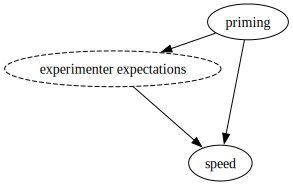

In [103]:
G = Digraph()
G.graph_attr['layout'] = 'neato'

G.node("a",'priming',pos="200,400")
G.node("b",'experimenter expectations',pos="0,200",style="dashed")
G.node("c","speed",pos="100,0")

G.edge("a",'c',len='2.0')
G.edge("a",'b',len='2.0')
G.edge("b",'c',len='2.0')

G

It does matter, however, that the story is convincing. I don't need to know for sure it's true. But I do need to know it's possible, that we have a clear set of assumptions to underpin the story and we have at least some reason to believe those assumptions. Exploring completely arbitrary, far-fetched causal graphs is a nice exercise in pure computer science but less interesting for applied behavioural science.

Then we generate a new dataset that resembles the only dataset. I should get speeds in a similar range, I should have a similar amount of noise.

In [88]:
primed_sim = np.random.choice([0,1],size=30)

experimenter_p = invlogit(-2 + 3 * primed_sim)
experimenter_bias = np.random.binomial(n=1,p=experimenter_p)

speed_sim = 7.3 + 0.9 * experimenter_bias + 0.1 * primed + np.random.normal(0,1,size=30)
speed_sim

array([ 8.81939216,  7.32120957,  6.32364164,  7.87483586, 11.15809101,
        7.05074088,  9.71598164,  7.40399688,  6.38378394,  7.07182144,
        8.17020914,  9.08153898,  6.55435826,  7.31944671,  7.79740386,
        8.09389035,  8.93708241,  6.38053058,  7.56092411,  8.34043495,
        7.38086525,  6.41484132,  9.36491688,  8.51889115,  7.08878898,
        7.72128803,  8.25607162,  7.41218132,  7.61758792,  6.19644888])

The primed and unprimed groups have similar means. So it a bit like building a counterfeit currency. It looks the same. But underneath, all the processes are different.

In [89]:
speed_sim[primed_sim == 1].mean(), speed_sim[primed_sim == 0].mean()

(8.232594093393267, 7.0953751686568625)

If we refit the old statistical model, then we get the same results.

In [90]:
with pm.Model() as model_2:
    a = pm.Normal('a',10,5)
    b = pm.Normal('b',0,10)
    s = pm.Gamma('s',mu=3,sigma=1)
    
    mean = a + b*primed_sim
    
    y = pm.Normal('y',mean,s,observed=speed_sim)
    
    trace_sim_data = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [91]:
az.summary(trace_sim_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,7.107,0.340,6.478,7.757,0.008,0.006,1903.0,1856.0,1.0
b,1.126,0.433,0.253,1.901,0.010,0.007,1837.0,1869.0,1.0
s,1.153,0.171,0.850,1.466,0.004,0.003,2133.0,2107.0,1.0


So at this point we can forward an argument like this, "if we are right about the causal structure, then the original estimates were biased." It's a conditional argument. It doesn't prove that the original estimates were biased. But it does challenge the logical validity of the original experiment by presenting an alternative explanation. Moreover, we've rigourly built up that alternative explanation into a model and showed that it can trick the original statistical analysis. It's a powerful style of argument that you can redeploy on other studies.